# Dynamic model

In [1]:
#| echo: false

# Ignore warning about depreciated modules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
#| echo: false

# Import path of model
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, './src')

In [3]:
#| echo: false

# Enable interactive plotting
%matplotlib ipympl

## Conceptual diagram

![Conceptual diagram of shoot FSPM (not final version, some errors)](images/shoot_FSPM_conceptual_diagram_alone.jpg "Conceptual diagram")

The main stem grows according to the crop model's plant height. At the end of the growth of an internode, a leaf appears. The appearance of a leaf is triggered by fixed phyllochron (different for tillers?).  

Cf Fournier et al, 2005 for leaf elongation 

The angle of the leaf with its axis is leaf-age dependent. The leaf blade curvature depends on the angle with the axis and the leaf length.  

The reproductive organs appear from a given thermal time, when the leaves have stopped growing. 

Leaf senescence is constrained by crop model, as it has a direct influence on LAI (green LAI vs. yellow LAI ?).  

The branching pattern is set (Tillers (Zhu et al., 2015)). 

## Time-dependent parametrization of leaf area

$$ \mathcal{A_normalized} = 2 * |\int_{0}^{1} \mathcal{C}(s(u))ds(u)| $$
$$ \mathcal{A} = \mathcal{A_scaled} = 2 * w * |\int_{0}^{L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$
$$ \frac{d\mathcal{A}}{dt} = 2 * w * |\int_{ds(t)/L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$

- $\mathcal{A}$ : final leaf area (or surface), in $cm^2$ (given by crop model)
- $\frac{d\mathcal{A}}{dt}$ : gain in area, in $cm^2$, for a given leaf for a given time step $dt$ (given by crop model)  
- $\mathcal{C}$ : curve of the evolution of the leaf width along the leaf, **from tip to base** (literature/expert knowledge/observation)
- $s(t)$ : curvilinear abscissa of the midrib, in $cm$, as a function of thermal time $t$, such that: $ ds(t) = \sqrt{(dx(t))^2+(dy(t))^2} $ (computed from leaf curvature)
- $w$ : final maximal width of the leaf, in $cm$ (to fix/vary within a reasonable range)
- $L$ : final length of the leaf, in $cm$ (to fix/vary within a reasonable range)
- $t$ : thermal time, in $^oC.day$


The objective is to find, for each growing leaf, at each time step, and for a given leaf area provided to the leaf $\frac{d\mathcal{A}}{dt}$, how much length $ds(t)$ is added to the leaf.

$$ \frac{d\mathcal{A}}{dt} = 2w |\int_{s(t-1)/L}^{s(t)/L} \mathcal{C}(\frac{s(u)}{L})d\frac{s(u)}{L}| $$

According to the Fundamental Theorem of Calculus, $\mathcal{C}$ being at least $C^0$ on $[0,L]$, $F$ being the antiderivative of $\mathcal{C}$, we can write:

$$ \frac{d\mathcal{A}}{dt} = 2w (|F(\frac{s(t)}{L}) - F(\frac{s(t-1)}{L})|) $$

$$ F(\frac{s(t)}{L}) = |\frac{1}{2w} \frac{d\mathcal{A}}{dt} + F(\frac{s(t-1)}{L})| $$

Knowing the other variables, we know have to determine $s(t)$ at thermal time $t$.

In [4]:
#| echo: false
# drawing

## Apparition and growth of phytomers (stem and leaf)

The height of the plant/canopy (here we consider the height of the main stem) is given by the crop model.  
The plastochron (i.e. leaf initiation rate, in $leaf^{-1}$) is the time interval between two successive leaves produced at the SAM.  
The phyllochron (i.e. leaf emergence rate, in $leaf^{-1}$) is the time interval between two successive leaves emerging from the top of the former leaf sheath.  
The time for a leaf to grow is roughly between 1.5 and 2 phyllochrons.  
We consider a linear (rough approximation of beta function) growth for the leaf.  

- $\phi$ : phyllochron, in $^oC.day.leaf^{-1}$ (literature)
- cur_len_int : current length of growing internodes
- fin_len_int : final length of internodes, in $cm$ (literature, bell shaped model too ?)
- height : plant height, in $cm$ (given by crop model)
- $[s(t)]$ : current length of growing leaves, in $cm$ (computed before)
- fin_len_leaf : final length of leaves, in $cm$  (bell shaped model)
- leaf expansion duration, as $x * \phi$, in $^oC.day$ (literature, cf Clerget et al., 2008, etc)  

Cf Fournier et al, 2005; Stewart and Dwyer, 1993; Skinner and Nelson, 1995  



From crop model: 

## Modifying the MTG of a growing plant

There are several ways to conceive the MTG for a growing plant.  

At each thermal time step, the turtle visits each element and adds a value to a time series for each (almost) properties of the MTG.   

**OR**   

At each thermal time step, the MTG is replicated and the growing elements ar modified, and new elements are added if needed.  

In [5]:
## Imports

# from installed packages
import numpy as np
import matplotlib.pyplot as plt
from openalea.plantgl.all import Vector3

# from archicrop
from archicrop.cereals_leaf import parametric_leaf

## Code for generating a parametric leaf for a cereal 
pl=parametric_leaf(nb_segment=10, insertion_angle=40, scurv=0.7, curvature=90, alpha=-2.3)
# pl

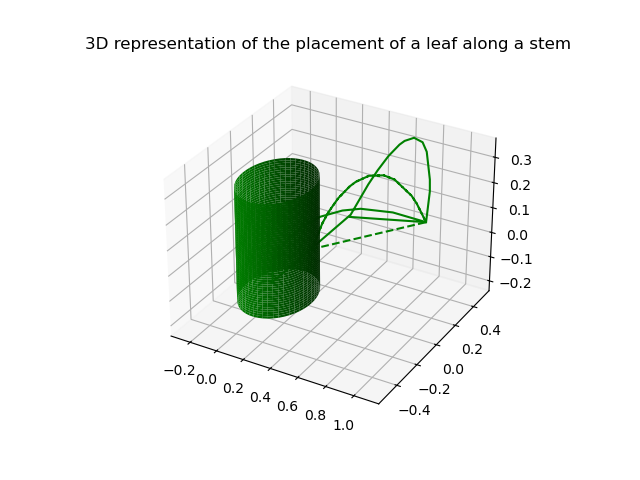

In [6]:
## Imports

# from installed packages
from math import pi, cos, sin, radians
import matplotlib.tri as mtri
import openalea.plantgl.all as pgl

# from archicrop
# from archicrop.cereals_leaf import arrange_leaf
# or 
from archicrop.geometry import arrange_leaf
from archicrop.fitting import leaf_to_mesh_2d

## Code for placing a leaf against a stem element (here a cylinder), with a given inclination
stem_diameter=0.5
inclination=1

al=arrange_leaf(leaf=pl, 
                stem_diameter=stem_diameter, 
                inclination=inclination, 
                relative=True)



x=al[0]
y=al[1]
s=al[2]
r=al[3]

pts,ind=leaf_to_mesh_2d(x, y, r)

xs=[pt[0] for pt in pts]
ys=[pt[1] for pt in pts]
zs=[pt[2] for pt in pts]
    
X,Y=np.meshgrid(xs, ys)

tri=mtri.Triangulation(xs, ys)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.plot(xs,ys,zs,c="green")
ax.plot([xs[0],xs[0]],[ys[0],-ys[0]],[0,0],c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")

radius=stem_diameter/2
z=np.linspace(-zs[-1], zs[-1])
theta=np.linspace(0, 2*np.pi)
theta_grid, z_stem=np.meshgrid(theta, z)
x_stem=radius*np.cos(theta_grid)
y_stem=radius*np.sin(theta_grid)

ax.plot_surface(x_stem, y_stem, z_stem, color="green")

ax.set_title("3D representation of the placement of a leaf along a stem")

plt.show()

In [7]:
## Imports

# from installed packages
from oawidgets.plantgl import *

# Set nice color for plants
nice_green=Color3((50,100,0))

In [8]:
## Imports

# from installed packages
from oawidgets.plantgl import *

# from archicrop
from archicrop.plant_shape import geometric_dist, bell_shaped_dist
from archicrop.plant_design import leaf_azimuth
from archicrop.cereals import build_shoot
from archicrop.display import display_mtg, build_scene, display_scene

# Enable plotting with PlantGL
%gui qt

## Code for generating a 3D cereal shoot from descritive parameters
# Parameters 
stem_radius=1 
height=1500                 # from crop model
nb_phy=15                   # fixed max nb of phytomers
max_leaf_length=70 
insertion_angle=40
scurv=0.7
curvature=80
phyllotactic_angle=120
spiral=True

# Functions calls
insertion_heights=np.array(geometric_dist(height, 
                                          nb_phy, 
                                          q=1.2)) # further separate stem and pseudo stem, cf simple maize

leaf_lengths=np.array(bell_shaped_dist(max_leaf_length=max_leaf_length, 
                                       nb_phy=nb_phy, 
                                       rmax=0.7, 
                                       skew=0.15)) # plant area --> max leaf length
# leaf_areas=bell_shaped_dist(plant_area=1, nb_phy=15, rmax=0.7, skew=0.15) # cf blade_dimension

a_leaf = parametric_leaf(nb_segment=10, 
                         insertion_angle=insertion_angle, 
                         scurv=scurv, 
                         curvature=curvature, 
                         alpha=-2.3)

leaf_shapes = [a_leaf for l in leaf_lengths] # possible to replace leaf_length by nb_phy or...

leaf_azimuths = leaf_azimuth(size=len(leaf_lengths), 
                             phyllotactic_angle=phyllotactic_angle, 
                             phyllotactic_deviation=15, 
                             plant_orientation=0, 
                             spiral=spiral)

shoot, g = build_shoot(stem_radius=stem_radius, 
                              insertion_heights=insertion_heights, 
                              leaf_lengths=leaf_lengths, 
                              leaf_areas=None, 
                              leaf_shapes=leaf_shapes, 
                              leaf_azimuths=leaf_azimuths)

# Build and display scene
scene, nump = build_scene(g, 
                                 leaf_material=Material(nice_green), 
                                 stem_material=Material(nice_green))
# display_scene(scene_single) # display in separate window
PlantGL(scene) # display in notebook

    plant  ntop    L_blade   W_blade     S_blade       h_ins  L_sheath  \
0       1    15  24.742494  2.474249   45.914326   17.154203         0   
1       1    14  29.233877  2.923388   64.096467   20.585043         0   
2       1    13  34.366259  3.436626   88.577983   24.702052         0   
3       1    12  40.060493  4.006049  120.363235   29.642462         0   
4       1    11  46.150221  4.615022  159.738216   35.570954         0   
5       1    10  52.364867  5.236487  205.655945   42.685145         0   
6       1     9  58.324393  5.832439  255.130109   51.222174         0   
7       1     8  63.553537  6.355354  302.928903   61.466609         0   
8       1     7  67.521763  6.752176  341.939137   73.759931         0   
9       1     6  69.710412  6.971041  364.465611   88.511917         0   
10      1     5  69.700616  6.970062  364.363191  106.214301         0   
11      1     4  67.266055  6.726605  339.354159  127.457161         0   
12      1     3  62.446908  6.244691  

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [9]:
for n in g.vertices():
    print(g.node(n).label, g.node(n).scale())

None 0
Plant 1
MainAxis 2
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3
Stem 3
Leaf 3


In [10]:
from archicrop.dynamic import thermal_time

thermal_time(g)

In [11]:
from ipywidgets import interact, interactive, IntSlider, fixed
from archicrop.dynamic import mtg_turtle_time

def grow_plant(time, g=g):
    #tm = 2000
    tt=time
    g = mtg_turtle_time(g, time=time)
    # Build and display scene
    scene, nump = build_scene(g, 
                              leaf_material=Material(nice_green), 
                              stem_material=Material(nice_green))
    w=PlantGL(scene, group_by_color=True)
    w.wireframe=True
    return w

In [12]:
max_time = max(g.property('end_tt').values())
interact(grow_plant, time=IntSlider(min=20, max=max_time+1, step=100, value=1000), g=fixed(g))

interactive(children=(IntSlider(value=1000, description='time', max=1717, min=20, step=100), Output()), _dom_c…

<function __main__.grow_plant(time, g=<openalea.mtg.mtg.MTG object at 0x000001F21714EF00>)>

In [13]:
from oawidgets.mtg import plot as MTGw
MTGw(g, properties='label')
# g.display()

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [14]:
## Code for generating a growing cereal shoot from descritive parameters
# Fix a seed
# seed(1)

# Initialize the list of plant MTGs at different stages
growing_plants=[]
# positions=[(x,0,0) for x in range(0, 3600, 100)]
positions=[(x,0,0) for x in range(0, 600, 100)]

# For loop for generating plants at different stages
# for time in range(200,2000,50):
for time in range(1000,1300,50):
    gg=mtg_turtle_time(g, time=time).sub_mtg(mtg_turtle_time(g, time=time).root) 
    # Fill the list with MTG of "growing" plant
    growing_plants.append(gg)

    # i=0
    # for v in g.vertices():
    #     n=gg.node(v)
    #     if n.label is not None and n.label.startswith('Stem'):
    #         print(n.label, i, n.visible_length)
    #     i+=1
    # print('')

# Build and display scene
scene_grow, nump = build_scene(growing_plants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
# display_scene(scene_grow)
PlantGL(scene_grow)

Stem 3 17.154202550617022
Stem 5 3.430840510123403
Stem 7 4.117008612148087
Stem 9 4.940410334577699
Stem 11 5.928492401493241
Stem 13 7.114190881791885
Stem 15 8.537029058150267
Stem 17 10.24443486978032
Stem 19 8.381810348002077
Stem 21 0.8381810348002086
Stem 23 17.702383454980378
Stem 25 21.242860145976465
Stem 27 25.491432175171752
Stem 29 30.58971861020612
Stem 31 36.70766233224731

Stem 3 17.154202550617022
Stem 5 3.430840510123403
Stem 7 4.117008612148087
Stem 9 4.940410334577699
Stem 11 5.928492401493241
Stem 13 7.114190881791885
Stem 15 8.537029058150267
Stem 17 10.24443486978032
Stem 19 11.874231326336275
Stem 21 5.029086208801251
Stem 23 17.702383454980378
Stem 25 21.242860145976465
Stem 27 25.491432175171752
Stem 29 30.58971861020612
Stem 31 36.70766233224731

Stem 3 17.154202550617022
Stem 5 3.430840510123403
Stem 7 4.117008612148087
Stem 9 4.940410334577699
Stem 11 5.928492401493241
Stem 13 7.114190881791885
Stem 15 8.537029058150267
Stem 17 10.24443486978032
Stem 19 11.

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## Next steps

- Constrains from crop model
- Bending dynamics of leaves and tillers